In [7]:
import os
import numpy as np
import pickle
import bisect
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from evo.tools.settings import SETTINGS
from evo.tools import plot

from tools.internal.plot_settings import get_figsize

from copy import deepcopy

%matplotlib widget

result_figure_dir = "/mnt/c/Users/J-Dau/OneDrive/TUM/04_SS23/02_MA/02_Figures/08_ch-6-results/07_global_consistency/"

## First

In [3]:
data_root = "/home/julian/projects/thesis/datasets/converted"

data = {
"front": os.path.join(data_root, "mdv3_innovusion_front"),
"rear":  os.path.join(data_root, "mdv3_innovusion_rear"),
"left":  os.path.join(data_root, "mdv3_ouster_left"),
"right": os.path.join(data_root, "mdv3_ouster_right")
}

In [4]:
for i, path in data.items():
    stamps = np.loadtxt(os.path.join(path, "times", "lidar_timestamps.txt"))
    first = stamps[0,0] #+ stamps[0,1] * 1e9
    timestamps = stamps[:,0] - first + stamps[:,1] * 1e-9
    data[i] = timestamps

In [ ]:
for v in data.values():
    print(v.shape)

In [ ]:
# Find the minimum length among the arrays
min_length = min(min(arr.shape[0] for arr in data.values()), 500)

# Create an nx4 matrix by slicing each array to the minimum length
matrix = np.column_stack(((arr[:min_length] for arr in data.values())))
o_matrix = np.column_stack(((arr[:min_length] for key, arr in data.items() if key in ["left", "right"] )))
i_matrix = np.column_stack(((arr[:min_length] for key, arr in data.items() if key in ["front", "rear"] )))

In [6]:
def compute_difference(matrix):
    diff = []
    for i in range(min_length):
        minv = np.min(matrix[i,:])
        maxv = np.max(matrix[i,:])
        diff.append(maxv - minv)
    return diff

diff = compute_difference(matrix)
o_diff = compute_difference(o_matrix)
i_diff = compute_difference(i_matrix)

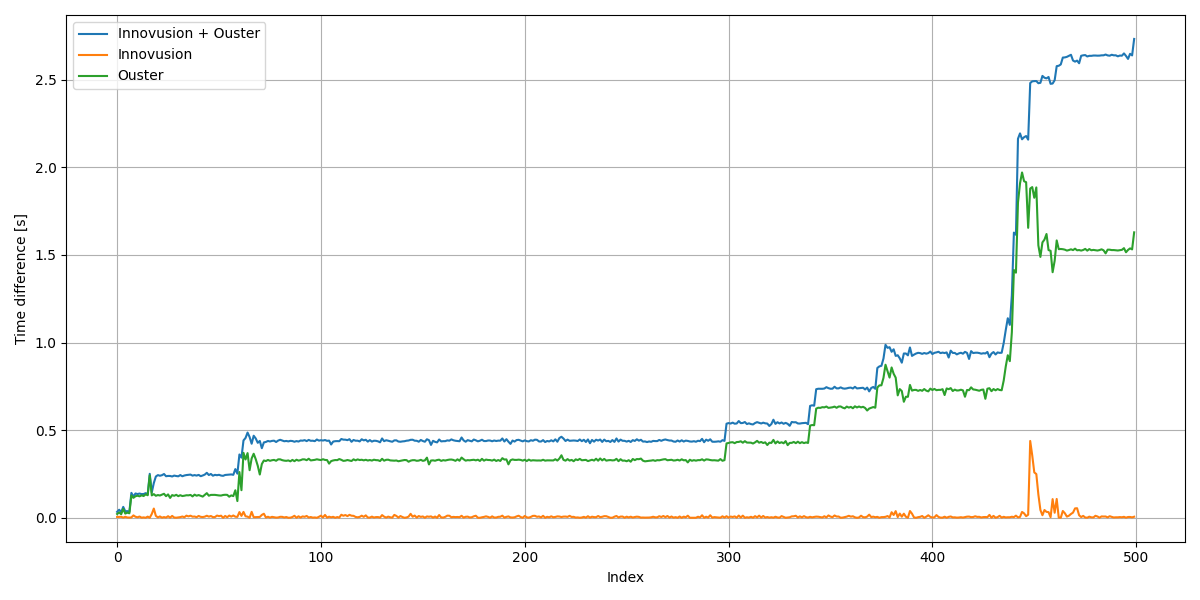

In [7]:
# Create a Matplotlib figure and axis
f = plt.figure(figsize=(12, 6))
# plt.title('Time difference between first and last LiDAR measurement')
plt.xlabel('Index')
plt.ylabel('Time difference [s]')

plt.plot(diff, label='Innovusion + Ouster')
plt.plot(i_diff, label='Innovusion')
plt.plot(o_diff, label='Ouster')
# Customize the legend
plt.legend(loc='best')

# Show the plot
plt.tight_layout()
plt.grid(True)
plt.show()

f.savefig('figures/time_differences.pdf')

In [ ]:
# Create a Matplotlib figure and axis
plt.figure(figsize=(12, 6))
plt.title('Arrival Time Comparison of Sensor Messages (Last 5 seconds)')
plt.xlabel('Time (s) since Start')
plt.ylabel('Sensor')

# Define colors for each sensor
colors = ['b', 'g', 'r', 'c']

# Plot arrival times for each sensor within the time span
for i, (sensor, timestamps) in enumerate(data.items()):
    # Filter timestamps within the specified time span
    filtered_timestamps = [t for t in timestamps if t <= 2]
    
    plt.scatter(filtered_timestamps, [sensor] * len(filtered_timestamps), label=sensor, color=colors[i], s=200)

# Customize the legend
plt.legend(loc='best')

# Show the plot
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# Calculate time differences for each sensor
# time_differences = {sensor: [(t - timestamps[0]).total_seconds() for t in timestamps] for sensor, timestamps in data.items()}
time_differences = data

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Histogram of Time Differences between Sensor Messages')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.hist(time_differences.values(), bins=20, label=list(time_differences.keys()), alpha=0.7)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# Create a violin plot of time differences
plt.figure(figsize=(10, 6))
plt.title('Violin Plot of Time Differences between Sensor Messages')
plt.xlabel('Sensor')
plt.ylabel('Time Difference (seconds)')
plt.violinplot(time_differences.values(), showmedians=True, showextrema=False)
plt.xticks(range(1, len(data) + 1), data.keys())
plt.grid(True)
plt.show()

In [ ]:
# Create a heatmap of message arrivals over time
plt.figure(figsize=(12, 6))
plt.title('Heatmap of Message Arrivals over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Sensor')

# Convert time differences to a 2D numpy array for the heatmap
time_diff_array = np.array([time_differences[sensor] for sensor in data.keys()])

# Plot the heatmap
plt.imshow(time_diff_array, cmap='viridis', aspect='auto')
plt.colorbar(label='Time Difference (seconds)')
plt.yticks(np.arange(len(data)), data.keys())
plt.grid(False)
plt.show()

In [ ]:
plt.close('all')
for i, (key, stamps) in enumerate(data.items()):
    print(stamps.shape)
    plt.scatter(stamps, i * np.ones(stamps.shape[0]), marker='x')
    
    
plt.show()

## Extract Timestamps from Rosbag

In [3]:
from rosbags.rosbag2.reader import Reader as BagReader
from rosbags.serde import deserialize_cdr

bag_path = "/mnt/e/thesis/datasets/mdv3_1/"

topics = [
    "/edgar/sensor/lidar/innovusion/front/points",
    "/edgar/sensor/lidar/innovusion/rear/points",
    "/edgar/sensor/lidar/ouster/left/points",
    "/edgar/sensor/lidar/ouster/right/points" ]


result = {t: [] for t in topics}

with BagReader(bag_path) as reader:
    
    # iterate over messages
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic in topics:
            msg = deserialize_cdr(rawdata, connection.msgtype) 
            stamp = msg.header.stamp.sec + msg.header.stamp.nanosec *1e-9
            result[connection.topic].append((stamp, timestamp))
            

In [6]:
with open("lidar_timestamps.pkl", 'wb') as f:
    pickle.dump(result, f)

In [57]:
with open("lidar_timestamps.pkl", 'rb') as f:
    times = pickle.load(f)
times = {s : [v[0] for v in time_list] for s,time_list in times.items()}

In [58]:
front = times["/edgar/sensor/lidar/innovusion/front/points"]
rear = times["/edgar/sensor/lidar/innovusion/rear/points"]
left = times["/edgar/sensor/lidar/ouster/left/points"]
right = times["/edgar/sensor/lidar/ouster/right/points"]

In [5]:
def create_combined_timeline(data, interval):
    # Flatten all timestamps and sort them
    all_timestamps = sorted(ts for timestamps in data.values() for ts in timestamps)

    # Create a combined timeline with intervals
    combined_timeline = []
    for ts in all_timestamps:
        # Add an interval start if it's not too close to the previous timestamp
        if not combined_timeline or ts - combined_timeline[-1] > interval:
            combined_timeline.append(ts - interval)
        
        combined_timeline.append(ts)  # Add the actual timestamp

        # Add an interval end if it's not too close to the next timestamp
        if combined_timeline[-1] != ts + interval:
            combined_timeline.append(ts + interval)

    return combined_timeline

def pad_sensor_data_with_intervals(data, interval):
    combined_timeline = create_combined_timeline(data, interval)

    # Pad shorter lists
    padded_data = {}
    for sensor, timestamps in data.items():
        padded_list = []
        for point in combined_timeline:
            # Find the position of the closest timestamp to the current point
            pos = bisect.bisect_left(timestamps, point)
            
            # Determine if the timestamp falls within the interval
            if pos < len(timestamps) and abs(timestamps[pos] - point) <= interval:
                padded_list.append(timestamps[pos])
            elif pos > 0 and abs(timestamps[pos - 1] - point) <= interval:
                padded_list.append(timestamps[pos - 1])
            else:
                padded_list.append(None)
        padded_data[sensor] = padded_list

    return padded_data

In [7]:
padded = pad_sensor_data_with_intervals(times, 0.1)

In [72]:
t_front = np.asarray(front)
t_rear = np.asarray(rear)
t_left = np.asarray(left)
t_right = np.asarray(right)

In [71]:
diff_inno = np.abs(t_front - t_rear)


max_ouster_idx = min(len(t_left), len(t_right))
diff_ouster = np.abs(t_left[:max_ouster_idx] - t_right[:max_ouster_idx])

print(np.max(diff_inno))
print(np.mean(diff_inno))
print(np.max(diff_ouster))
print(np.mean(diff_ouster))

3101
0.4384922981262207
0.04201709266940612
2.3612170219421387
0.9225797845788258


In [ ]:
times_l = deepcopy(t_left)
times_r = deepcopy(t_right)
for i in range(len(t_front)):
    front, rear = t_front[i], t_rear[i]
    ref_time = min(front, rear)
    t_l_idx = np.argmin(t_left)
    t_l = t_left[t_l_idx]
    times_l[t_l_idx] = None

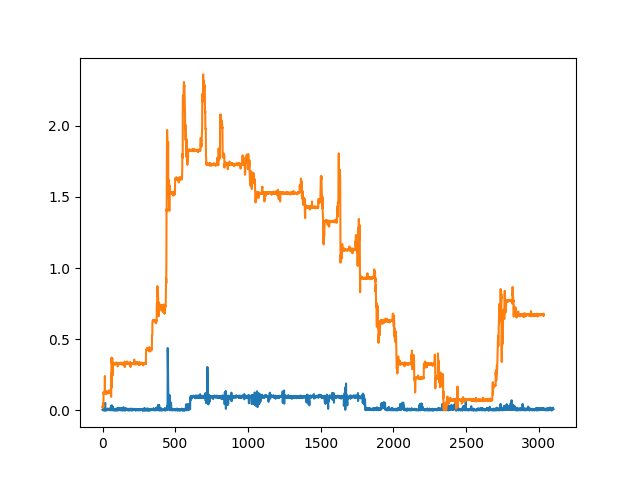

In [69]:
plt.figure()
plt.plot(diff_inno)
plt.plot(diff_ouster)

## Timestamps from files

In [9]:
root = "/home/julian/projects/thesis/datasets/timing/"

start = []
end = []


start_files, end_files = [], []

for file in os.listdir(root):
    if file.startswith("end"):
        end_files.append(file)
    elif file.startswith("start"):
        start_files.append(file)
        
for file in sorted(start_files):        
    with open(os.path.join(root,file), 'r') as f:
        sec, nsec = f.readline().split()
        stamp = float(sec) + float(nsec) * 1e-9
        start.append(stamp)
for file in sorted(end_files):        
    with open(os.path.join(root,file), 'r') as f:
        sec, nsec = f.readline().split()
        stamp = float(sec) + float(nsec) * 1e-9
        end.append(stamp)
        
start = np.asarray(start)
end = np.asarray(end)

In [16]:
print(start[0])
print(end[0])

1689869691.5252566
1689869691.5593135


In [56]:
print(np.argmax(diffs))
print(np.max(diffs))

436
0.13602209091186523


Mean: 0.039291550204121777, Std: 0.00957573851981157


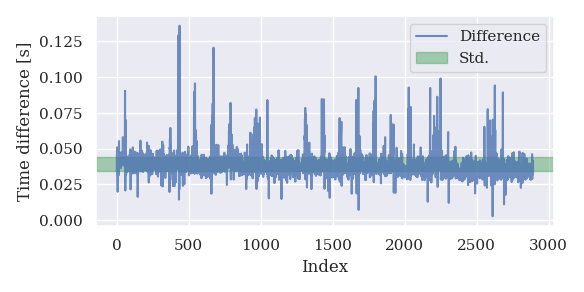

In [14]:
diffs = np.abs(start - end)

mean = np.mean(diffs)
std = np.std(diffs)

print(f"Mean: {mean}, Std: {std}")
color_pallete = itertools.cycle(sns.color_palette())

plt.figure(figsize=get_figsize(wf=1, hf=0.5))
plt.plot(diffs, color=next(color_pallete), alpha=0.8)
plt.xlabel("Index")
plt.ylabel("Time difference [s]")

plt.tight_layout()
ax = plt.gca()
plt.axhspan(mean - std / 2, mean + std / 2, alpha=0.5, color=next(color_pallete))

plt.legend(["Difference", "Std."])
plt.savefig(os.path.join(result_figure_dir, "lidar_timing"), format="pdf", bbox_inches="tight")

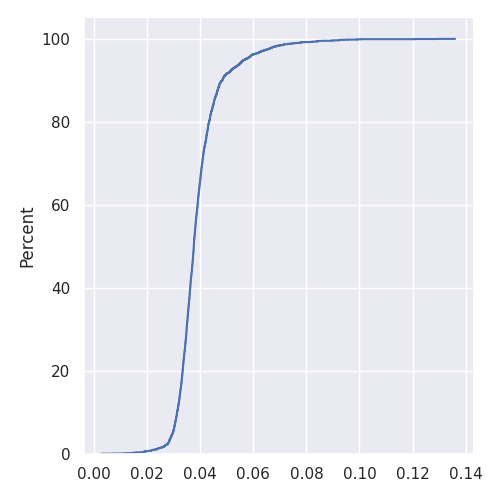

In [53]:
plt.close('all')
g = sns.displot(data=diffs, kind='ecdf', stat="percent")
plt.show()

In [5]:
from scipy.spatial.transform import Rotation as R

rot = R.from_matrix(np.asarray([
,
,
)



[  0.   0. -11.]
